In [3]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from dateutil import parser
import datetime
import warnings
warnings.filterwarnings('ignore')

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model, Sequential, load_model
from keras import regularizers


Using TensorFlow backend.


In [4]:
from sklearn import preprocessing

In [5]:
#set random seed
seed(10)
set_random_seed(10)

In [6]:
data = pd.read_csv('5P7_pump_3_processed.csv', index_col='Date')

In [47]:
print(len(data.columns))
data.head()


11


,Motor Speed,Motor Torque,Output Neutral Voltage,Phase 'A' RMS Output Voltage,Phase 'B' RMS Output Voltage,Phase 'C' RMS Output Voltage,Phase 'A' RMS Output Current,Phase 'B' RMS Output Current,Phase 'C' RMS Output Current,Output Power,Torque/Speed
Date,,,,,,,,,,,
2019-02-03 00:00:00,50.119999,14.653001,3.000000,655.000000,666.000000,657.000000,27.000000,28.000000,28.000000,35.000000,0.292358
2019-02-03 01:00:00,50.050000,14.434424,3.827080,658.609009,669.609009,660.000000,27.000000,27.609026,28.000000,34.390972,0.288400
2019-02-03 02:00:00,50.076981,14.890259,2.385459,658.072693,668.458191,659.458191,27.385458,27.614542,28.000000,35.000000,0.297347
2019-02-03 03:00:00,50.092164,14.511855,2.000000,653.204712,666.192932,656.795288,27.000000,27.000000,27.602365,35.000000,0.289703
2019-02-03 04:00:00,50.119999,14.914515,4.390373,657.561462,667.951843,658.561462,27.000000,27.000000,28.000000,35.000000,0.297576


In [8]:
#transform data file index into datetime and sort in chronological order
data.index = pd.to_datetime(data.index, format='%Y.%m.%d %H:%M')
data = data.sort_index()
data.head()

,Motor Speed,Motor Torque,Output Neutral Voltage,Phase 'A' RMS Output Voltage,Phase 'B' RMS Output Voltage,Phase 'C' RMS Output Voltage,Phase 'A' RMS Output Current,Phase 'B' RMS Output Current,Phase 'C' RMS Output Current,Output Power,Torque/Speed
Date,,,,,,,,,,,
2019-02-03 00:00:00,50.119999,14.653001,3.000000,655.000000,666.000000,657.000000,27.000000,28.000000,28.000000,35.000000,0.292358
2019-02-03 01:00:00,50.050000,14.434424,3.827080,658.609009,669.609009,660.000000,27.000000,27.609026,28.000000,34.390972,0.288400
2019-02-03 02:00:00,50.076981,14.890259,2.385459,658.072693,668.458191,659.458191,27.385458,27.614542,28.000000,35.000000,0.297347
2019-02-03 03:00:00,50.092164,14.511855,2.000000,653.204712,666.192932,656.795288,27.000000,27.000000,27.602365,35.000000,0.289703
2019-02-03 04:00:00,50.119999,14.914515,4.390373,657.561462,667.951843,658.561462,27.000000,27.000000,28.000000,35.000000,0.297576


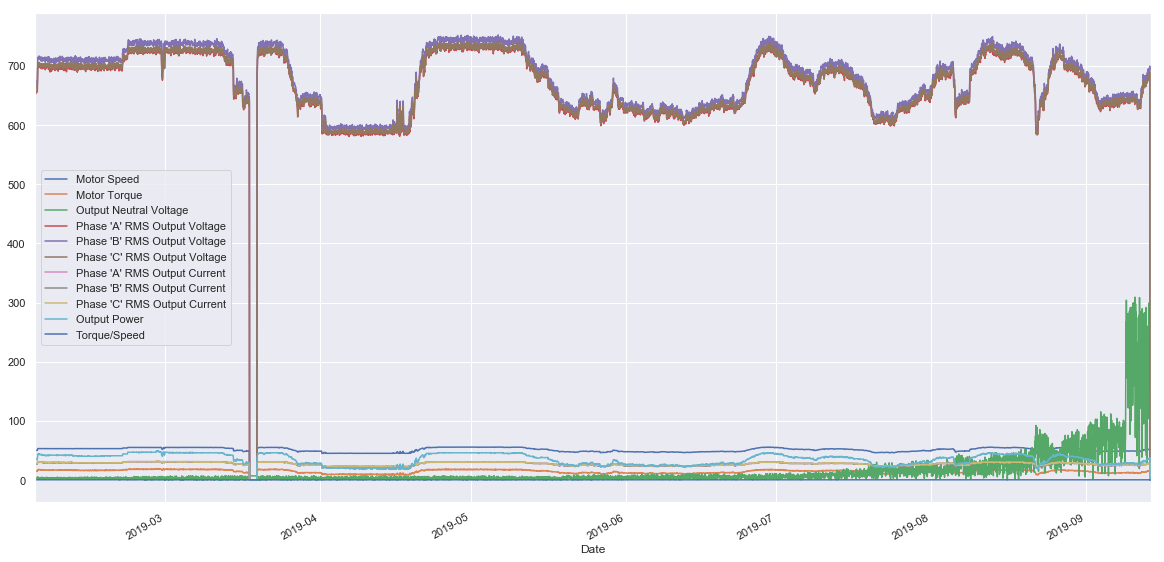

In [9]:
data.plot(figsize=(20,10))

In [29]:
 plt.savefig('books_read.png')

<Figure size 432x288 with 0 Axes>

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [11]:
data_scaled = scaler.fit_transform(data)

In [12]:
data_scaled.shape

(5352, 11)

In [13]:
principalDf = pd.DataFrame(data = data_scaled, 
                           columns = data.columns,
                           index=data.index)

In [14]:
principalDf.head()

,Motor Speed,Motor Torque,Output Neutral Voltage,Phase 'A' RMS Output Voltage,Phase 'B' RMS Output Voltage,Phase 'C' RMS Output Voltage,Phase 'A' RMS Output Current,Phase 'B' RMS Output Current,Phase 'C' RMS Output Current,Output Power,Torque/Speed
Date,,,,,,,,,,,
2019-02-03 00:00:00,-0.098336,0.085763,-0.357223,-0.126329,-0.125250,-0.126459,0.031221,0.307386,0.257526,0.024888,0.287575
2019-02-03 01:00:00,-0.110788,0.015828,-0.333327,-0.078332,-0.078264,-0.086613,0.031221,0.198951,0.257526,-0.039803,0.185356
2019-02-03 02:00:00,-0.105989,0.161675,-0.374980,-0.085464,-0.093246,-0.093809,0.136259,0.200481,0.257526,0.024888,0.416413
2019-02-03 03:00:00,-0.103288,0.040603,-0.386117,-0.150205,-0.122738,-0.129178,0.031221,0.030041,0.145869,0.024888,0.219005
2019-02-03 04:00:00,-0.098336,0.169436,-0.317051,-0.092263,-0.099839,-0.105719,0.031221,0.030041,0.257526,0.024888,0.422320


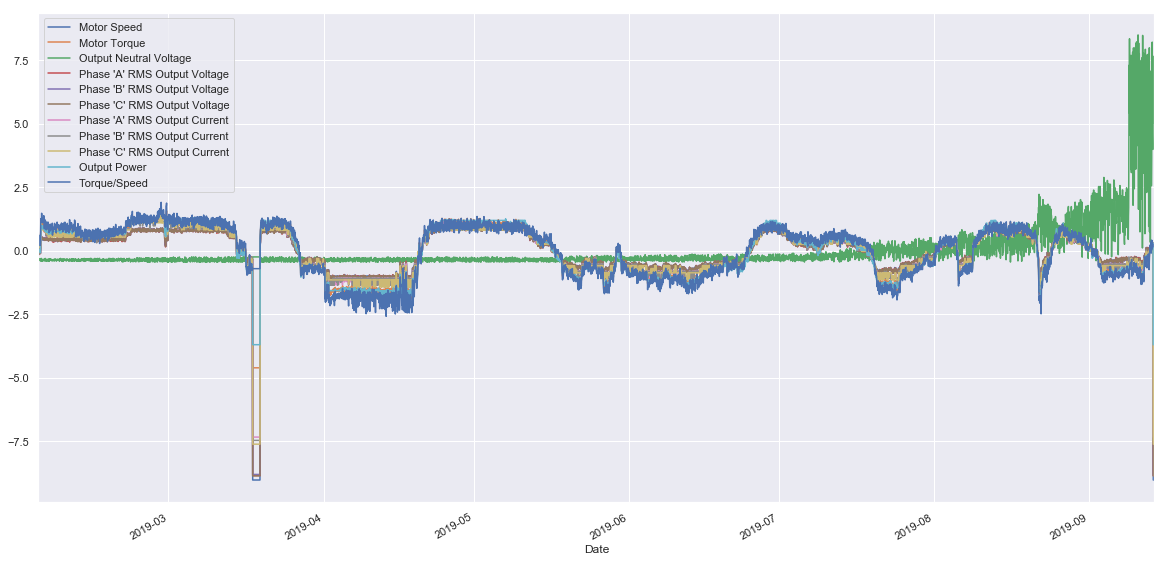

In [15]:
principalDf.plot(figsize=(20,10))

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5352 entries, 2019-02-03 00:00:00 to 2019-09-14 00:00:00
Data columns (total 11 columns):
Motor Speed                     5352 non-null float64
Motor Torque                    5352 non-null float64
Output Neutral Voltage          5352 non-null float64
Phase 'A' RMS Output Voltage    5352 non-null float64
Phase 'B' RMS Output Voltage    5352 non-null float64
Phase 'C' RMS Output Voltage    5352 non-null float64
Phase 'A' RMS Output Current    5352 non-null float64
Phase 'B' RMS Output Current    5352 non-null float64
Phase 'C' RMS Output Current    5352 non-null float64
Output Power                    5352 non-null float64
Torque/Speed                    5352 non-null float64
dtypes: float64(11)
memory usage: 501.8 KB


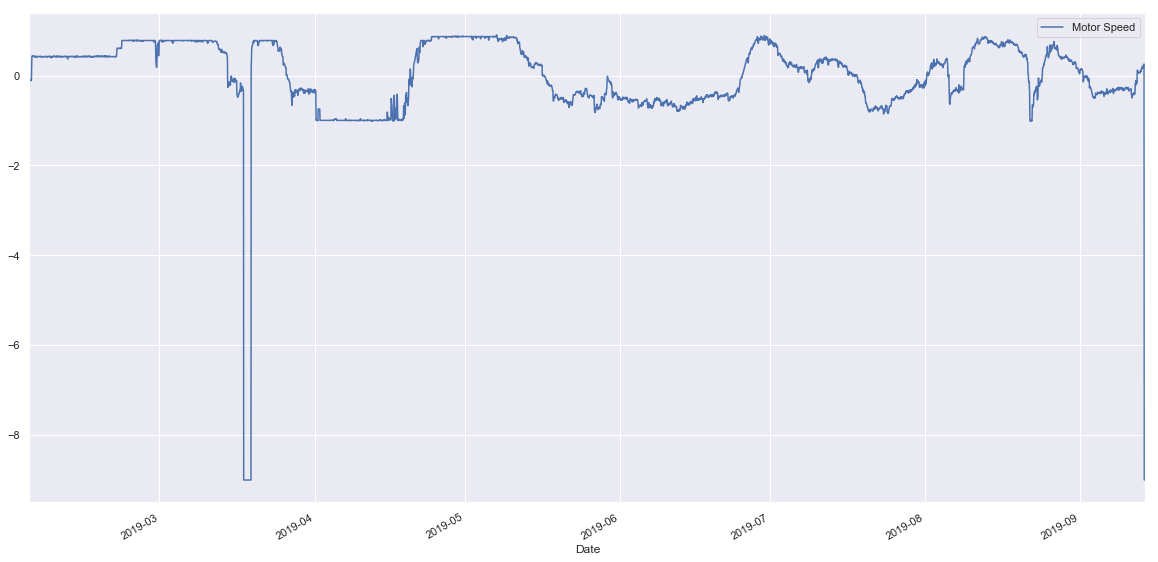

In [17]:
principalDf['Motor Speed'].plot(figsize=(20,10))
# principalDf['Motor Torque'].plot(figsize=(20,10))
# principalDf['Torque/Speed'].plot(figsize=(20,10))
plt.legend()

In [18]:
desired_date = data.index[0] + datetime.timedelta(days=156)
train_end_date = desired_date.strftime('%Y-%m-%d %H:%M').lstrip("0").replace(" 0"," ")
print(desired_date)
train_end_date

2019-07-09 00:00:00


'2019-07-09 0:00'

In [19]:
train = data[:train_end_date]
test  = data[train_end_date:]


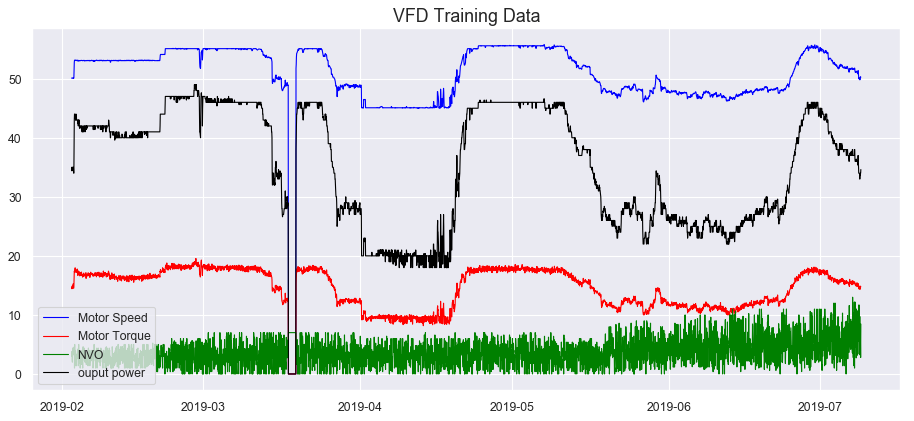

In [20]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Motor Speed'], label='Motor Speed', color='blue', animated = True, linewidth=1)
ax.plot(train['Motor Torque'], label='Motor Torque', color='red', animated = True, linewidth=1)
ax.plot(train['Output Neutral Voltage'], label='NVO', color='green', animated = True, linewidth=1)
ax.plot(train['Output Power'], label='ouput power', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('VFD Training Data', fontsize=16)
plt.show()

In [53]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)
print("Training dataset shape:", train_fft.shape)
print("Test dataset shape:", test_fft.shape)

Training dataset shape: (3744, 11)
Test dataset shape: (1609, 11)


(1609, 11)

In [55]:
frequency_Df_train = pd.DataFrame(data = train_fft
             , columns = data.columns, index=train.index )
frequency_Df_train.head()

,Motor Speed,Motor Torque,Output Neutral Voltage,Phase 'A' RMS Output Voltage,Phase 'B' RMS Output Voltage,Phase 'C' RMS Output Voltage,Phase 'A' RMS Output Current,Phase 'B' RMS Output Current,Phase 'C' RMS Output Current,Output Power,Torque/Speed
Date,,,,,,,,,,,
2019-02-03 00:00:00,2164.065358+0.000000j,-1129.488972-1258.933509j,-147.238965+1159.877195j,431.165983-273.941726j,227.756814+11.813658j,-188.567546-538.443645j,-188.567546+538.443645j,227.756814-11.813658j,431.165983+273.941726j,-147.238965-1159.877195j,-1129.488972+1258.933509j
2019-02-03 01:00:00,2173.817920+0.000000j,-1135.155056-1267.564265j,-148.941234+1165.585047j,433.160272-274.471627j,228.996167+13.048139j,-189.694110-539.665221j,-189.694110+539.665221j,228.996167-13.048139j,433.160272+274.471627j,-148.941234-1165.585047j,-1135.155056+1267.564265j
2019-02-03 02:00:00,2171.639120+0.000000j,-1134.106591-1264.274537j,-147.629889+1164.931341j,432.836080-274.653607j,229.420052+10.452887j,-190.915818-540.628477j,-190.915818+540.628477j,229.420052-10.452887j,432.836080+274.653607j,-147.629889-1164.931341j,-1134.106591+1264.274537j
2019-02-03 03:00:00,2159.689020+0.000000j,-1129.016173-1257.409460j,-144.624939+1161.435269j,430.662242-275.847965j,226.809995+11.161829j,-188.168734-536.601235j,-188.168734+536.601235j,226.809995-11.161829j,430.662242+275.847965j,-144.624939-1161.435269j,-1129.016173+1257.409460j
2019-02-03 04:00:00,2170.797231+0.000000j,-1131.173073-1265.542960j,-149.318242+1163.080921j,430.636241-274.249673j,229.274479+12.200078j,-189.158027-538.560462j,-189.158027+538.560462j,229.274479-12.200078j,430.636241+274.249673j,-149.318242-1163.080921j,-1131.173073+1265.542960j


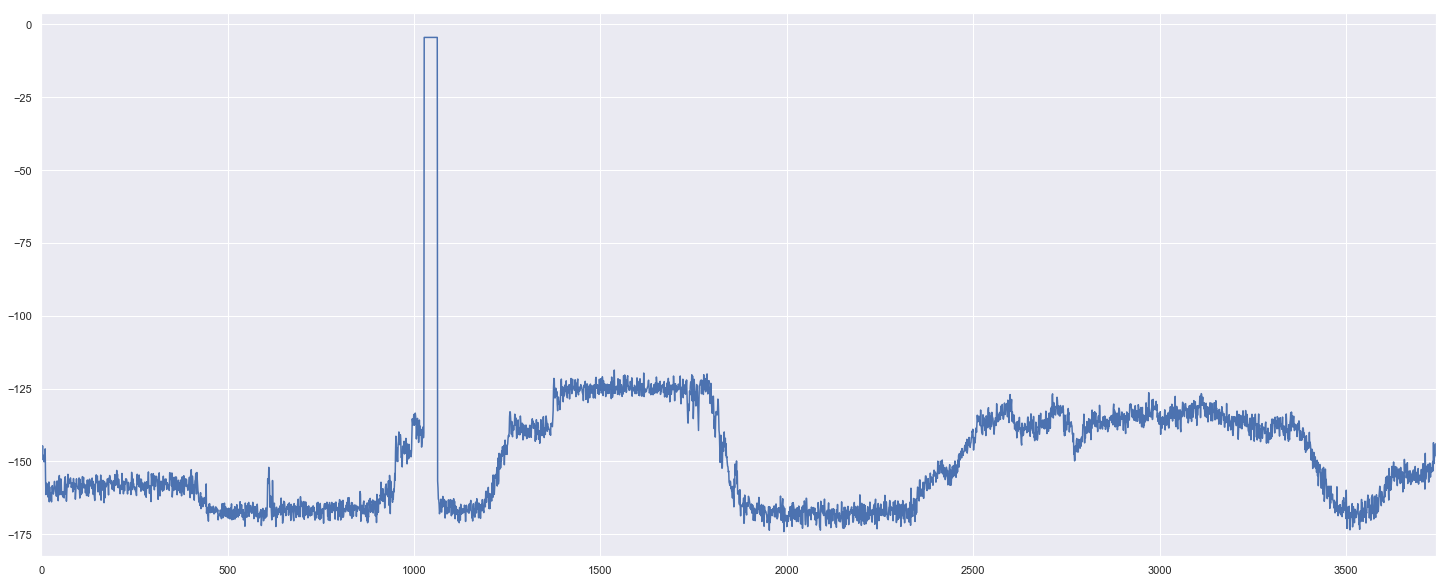

In [41]:
plt.Figure()
frequency_Df_train['Output Neutral Voltage'].plot(figsize=(25,10))


In [56]:
frequency_Df_test = pd.DataFrame(data = test_fft
             , columns = data.columns, index=test.index)
frequency_Df_test.head()

,Motor Speed,Motor Torque,Output Neutral Voltage,Phase 'A' RMS Output Voltage,Phase 'B' RMS Output Voltage,Phase 'C' RMS Output Voltage,Phase 'A' RMS Output Current,Phase 'B' RMS Output Current,Phase 'C' RMS Output Current,Output Power,Torque/Speed
Date,,,,,,,,,,,
2019-07-09 00:00:00,2183.455552+0.000000j,-1136.815010-1276.156434j,-148.583677+1167.111630j,427.881774-276.586520j,227.041300+18.507220j,-184.822153-538.506893j,-184.822153+538.506893j,227.041300-18.507220j,427.881774+276.586520j,-148.583677-1167.111630j,-1136.815010+1276.156434j
2019-07-09 01:00:00,2177.995836+0.000000j,-1129.225277-1275.400785j,-152.754260+1156.777155j,421.701770-271.081166j,227.702581+23.167585j,-181.147732-534.465492j,-181.147732+534.465492j,227.702581-23.167585j,421.701770+271.081166j,-152.754260-1156.777155j,-1129.225277+1275.400785j
2019-07-09 02:00:00,2189.444161+0.000000j,-1137.607347-1281.962522j,-152.794653+1166.678919j,427.877213-273.936030j,229.089283+20.562678j,-184.856565-538.307127j,-184.856565+538.307127j,229.089283-20.562678j,427.877213+273.936030j,-152.794653-1166.678919j,-1137.607347+1281.962522j
2019-07-09 03:00:00,2174.716413+0.000000j,-1135.617460-1270.112667j,-147.933089+1168.865046j,434.835294-273.790165j,230.352765+9.361889j,-191.795717-542.578508j,-191.795717+542.578508j,230.352765-9.361889j,434.835294+273.790165j,-147.933089-1168.865046j,-1135.617460+1270.112667j
2019-07-09 04:00:00,2193.055875+0.000000j,-1145.693792-1281.729874j,-149.204246+1179.334394j,436.781923-277.201479j,230.545535+11.505663j,-191.372364-545.662245j,-191.372364+545.662245j,230.545535-11.505663j,436.781923+277.201479j,-149.204246-1179.334394j,-1145.693792+1281.729874j


In [61]:

frequency_Df_test.corr()

,Motor Speed,Motor Torque,Output Neutral Voltage,Phase 'A' RMS Output Voltage,Phase 'B' RMS Output Voltage,Phase 'C' RMS Output Voltage,Phase 'A' RMS Output Current,Phase 'B' RMS Output Current,Phase 'C' RMS Output Current,Output Power,Torque/Speed
Motor Speed,1.000000,-0.869176,-0.446938,0.418090,0.787803,-0.206194,-0.206194,0.787803,0.418090,-0.446938,-0.869176
Motor Torque,-0.869176,1.000000,-0.053254,-0.812363,-0.985099,0.662346,0.662346,-0.985099,-0.812363,-0.053254,1.000000
Output Neutral Voltage,-0.446938,-0.053254,1.000000,0.624435,0.186351,-0.781180,-0.781180,0.186351,0.624435,1.000000,-0.053254
Phase 'A' RMS Output Voltage,0.418090,-0.812363,0.624435,1.000000,0.880997,-0.974715,-0.974715,0.880997,1.000000,0.624435,-0.812363
Phase 'B' RMS Output Voltage,0.787803,-0.985099,0.186351,0.880997,1.000000,-0.756147,-0.756147,1.000000,0.880997,0.186351,-0.985099
Phase 'C' RMS Output Voltage,-0.206194,0.662346,-0.781180,-0.974715,-0.756147,1.000000,1.000000,-0.756147,-0.974715,-0.781180,0.662346
Phase 'A' RMS Output Current,-0.206194,0.662346,-0.781180,-0.974715,-0.756147,1.000000,1.000000,-0.756147,-0.974715,-0.781180,0.662346
Phase 'B' RMS Output Current,0.787803,-0.985099,0.186351,0.880997,1.000000,-0.756147,-0.756147,1.000000,0.880997,0.186351,-0.985099
Phase 'C' RMS Output Current,0.418090,-0.812363,0.624435,1.000000,0.880997,-0.974715,-0.974715,0.880997,1.000000,0.624435,-0.812363
Output Power,-0.446938,-0.053254,1.000000,0.624435,0.186351,-0.781180,-0.781180,0.186351,0.624435,1.000000,-0.053254


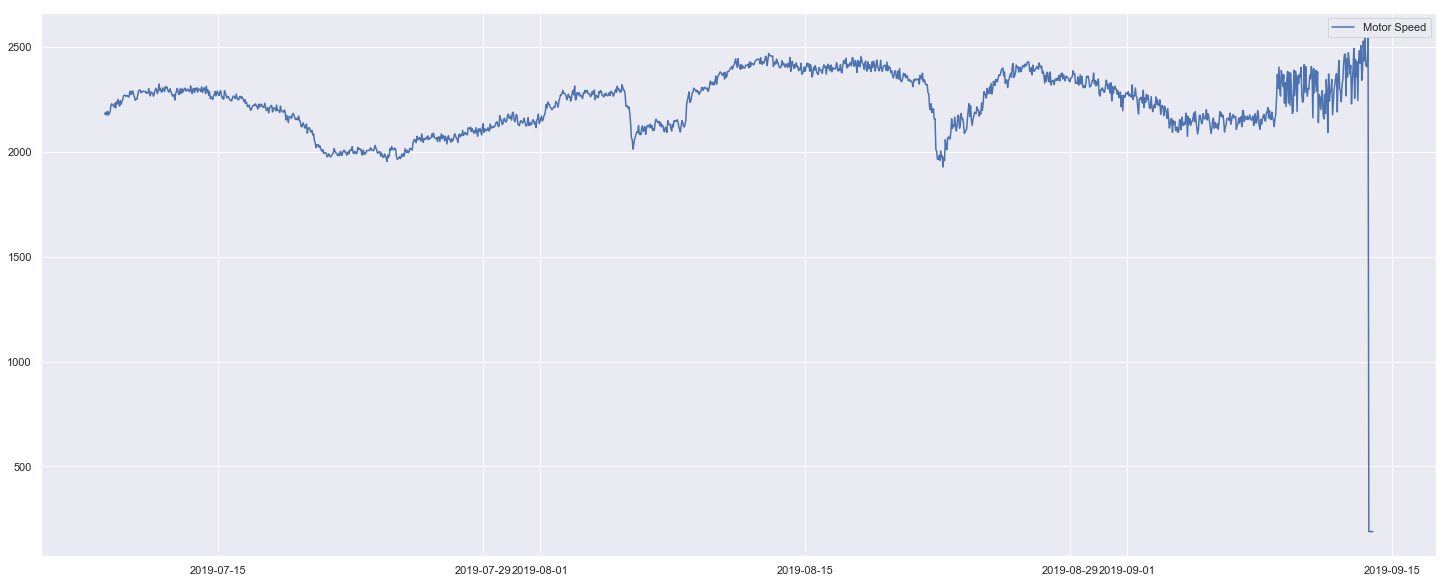

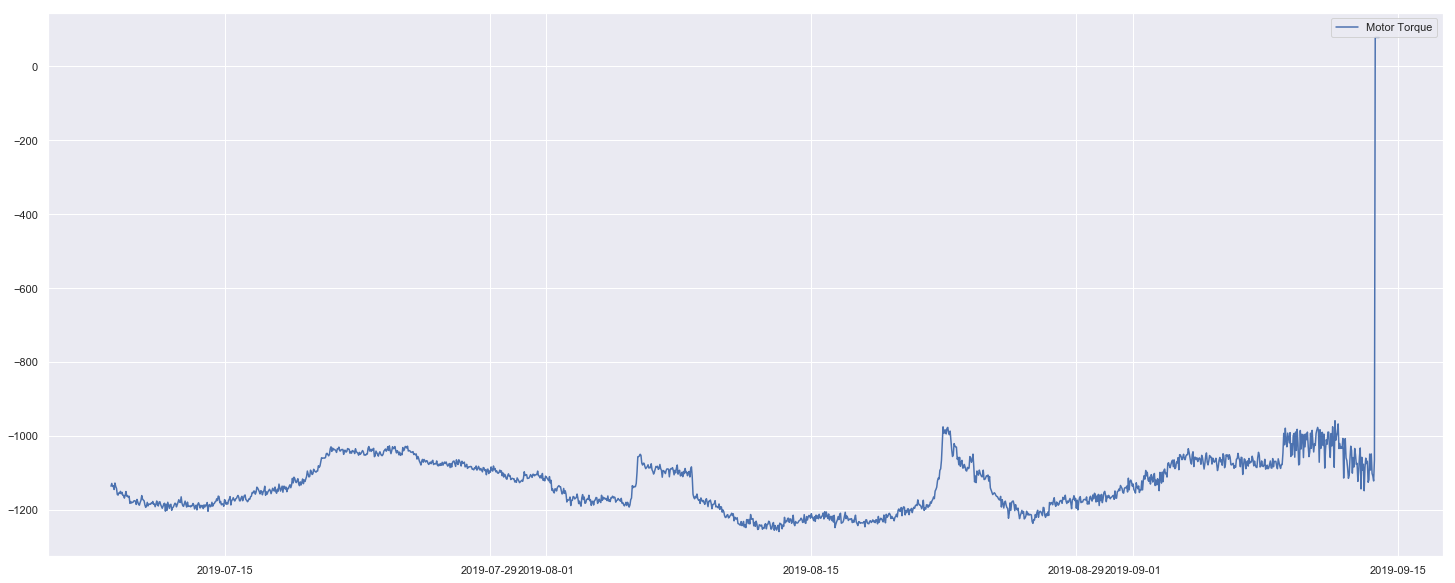

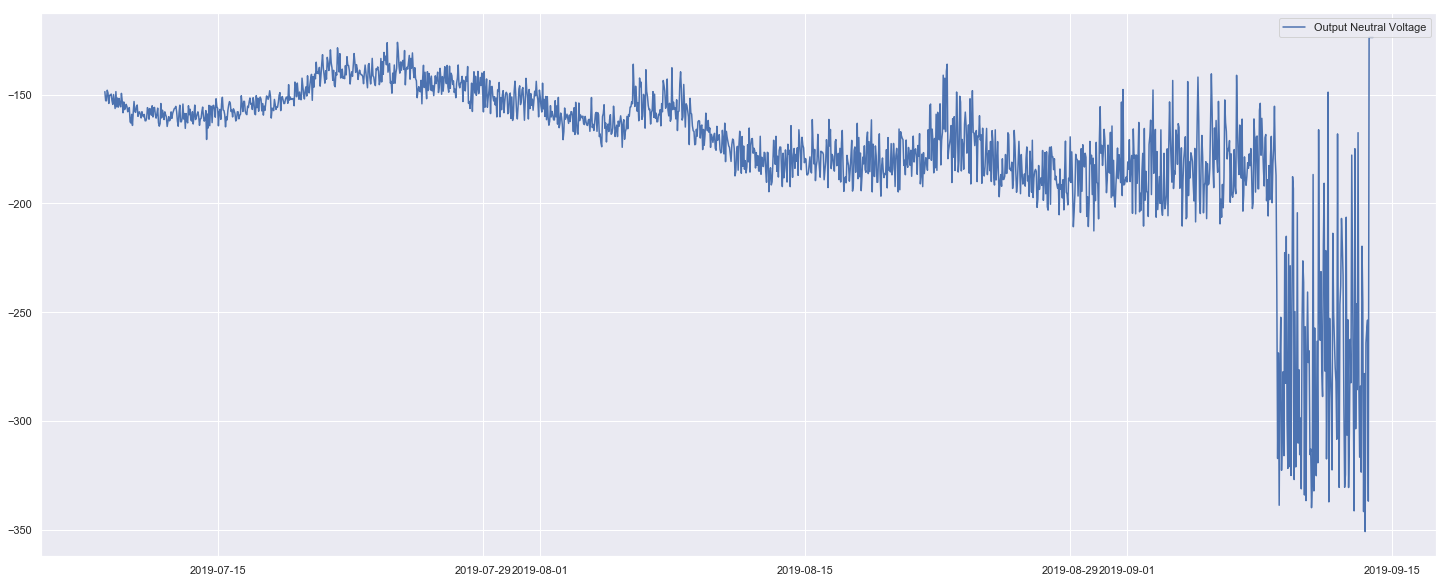

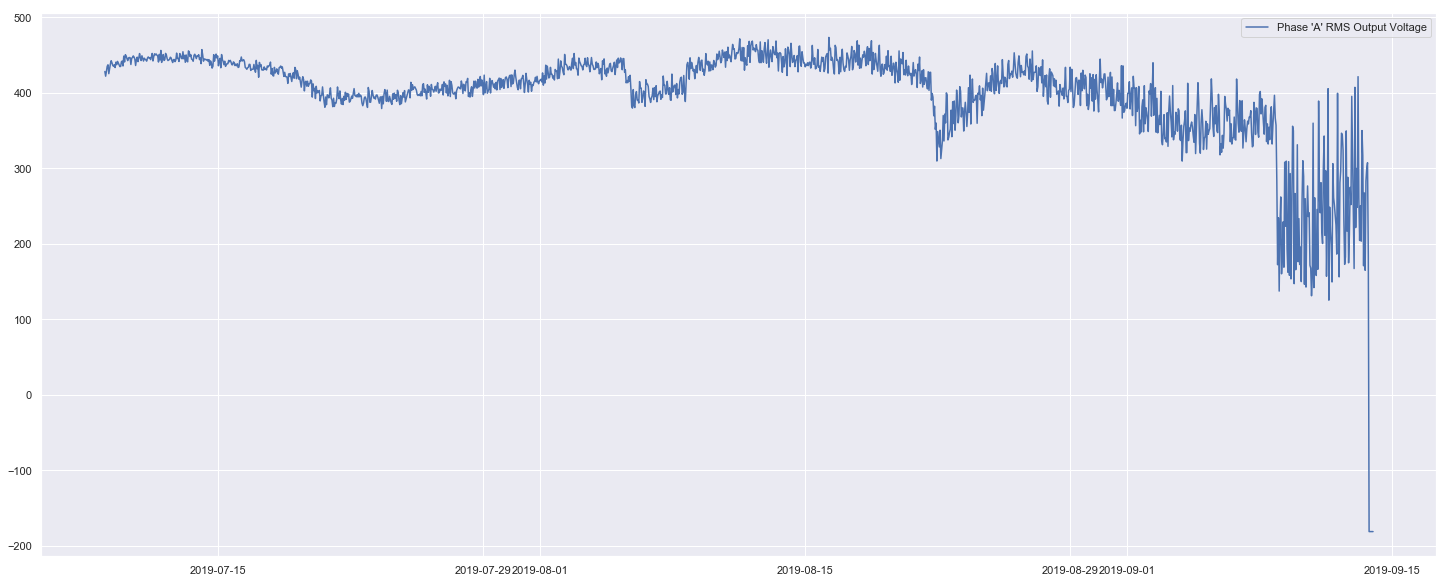

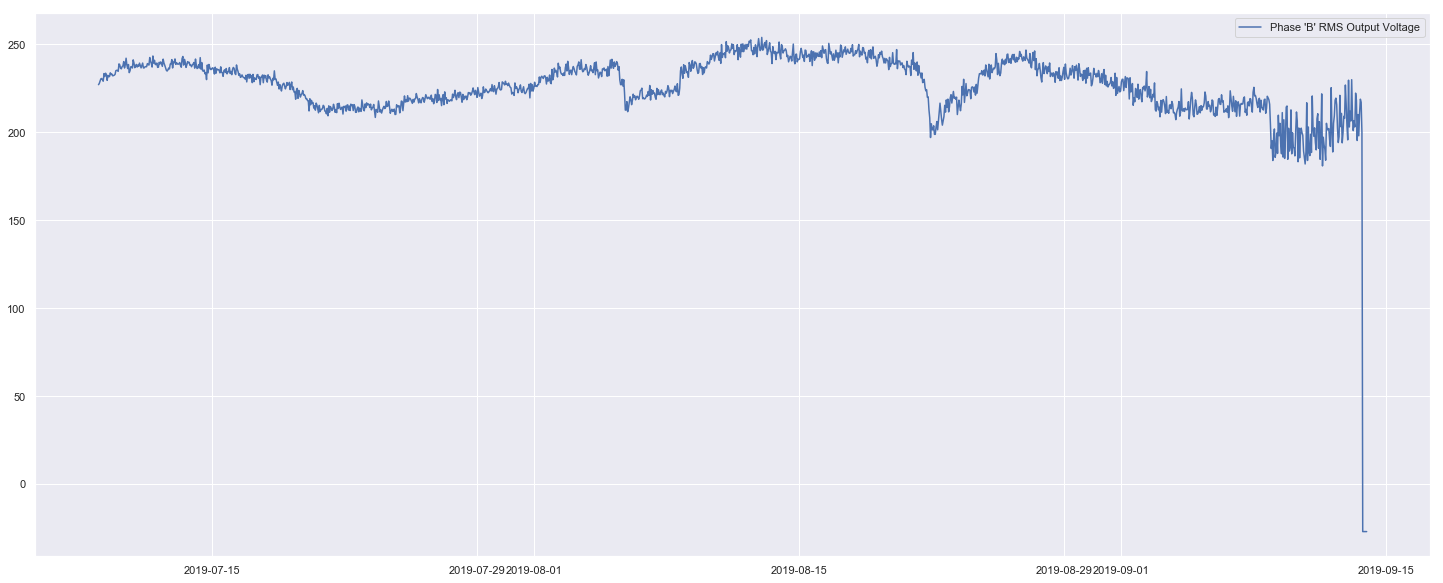

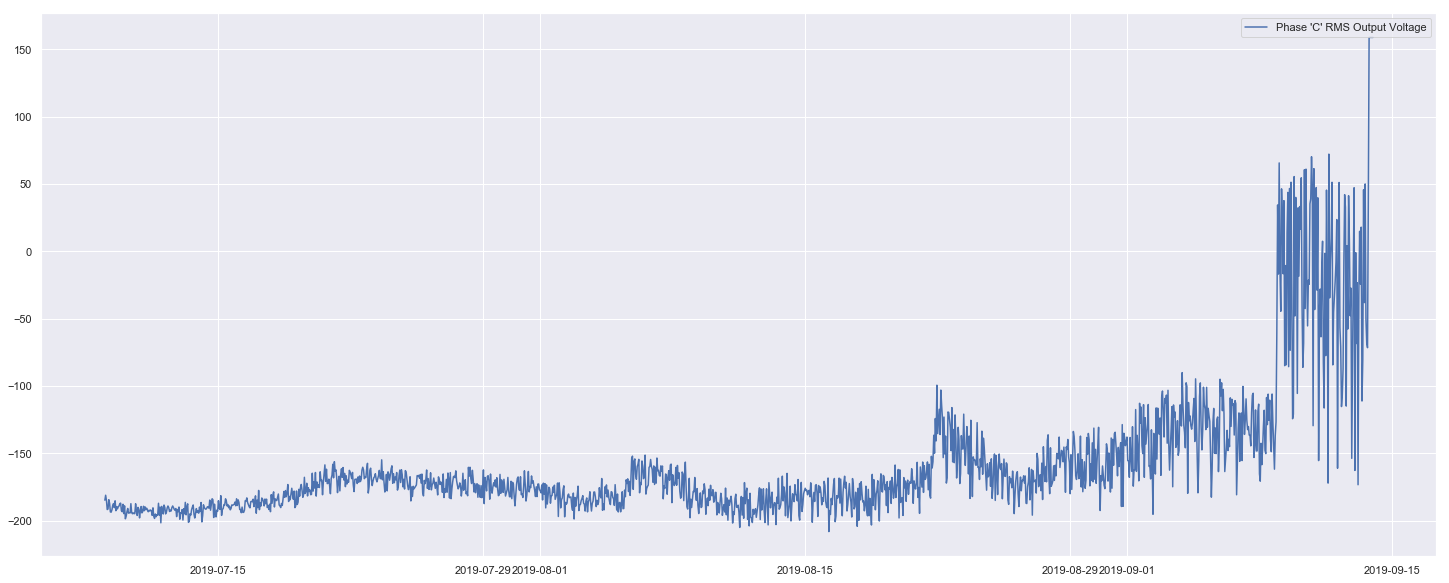

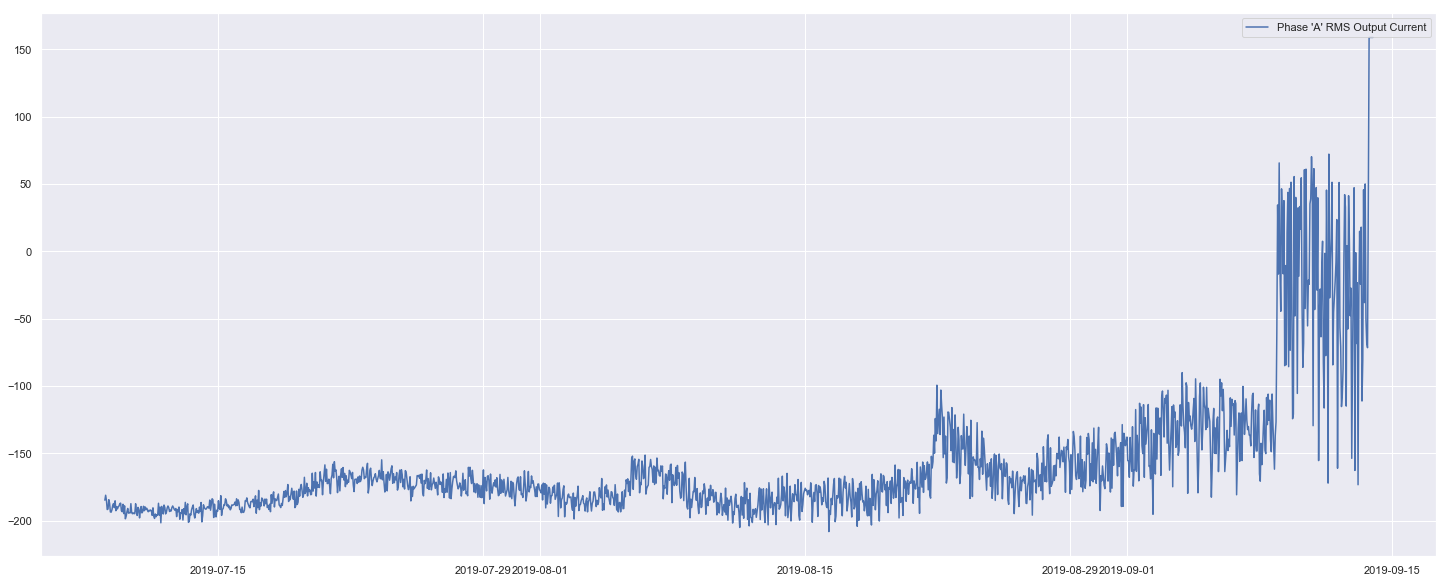

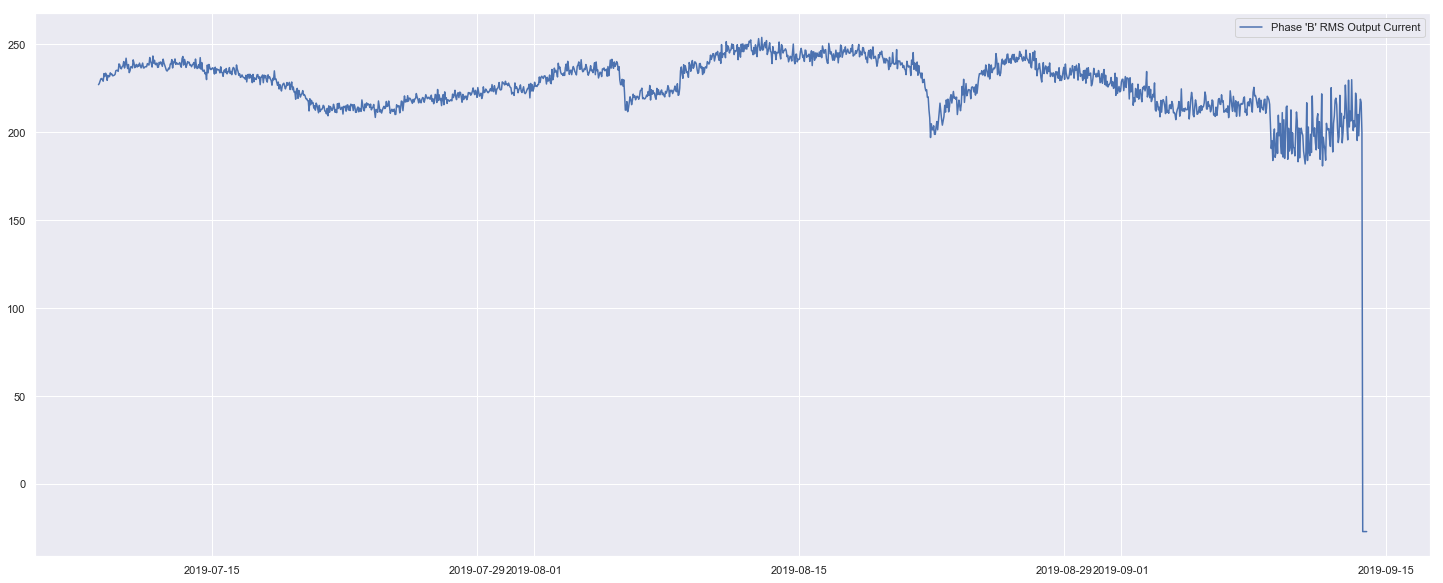

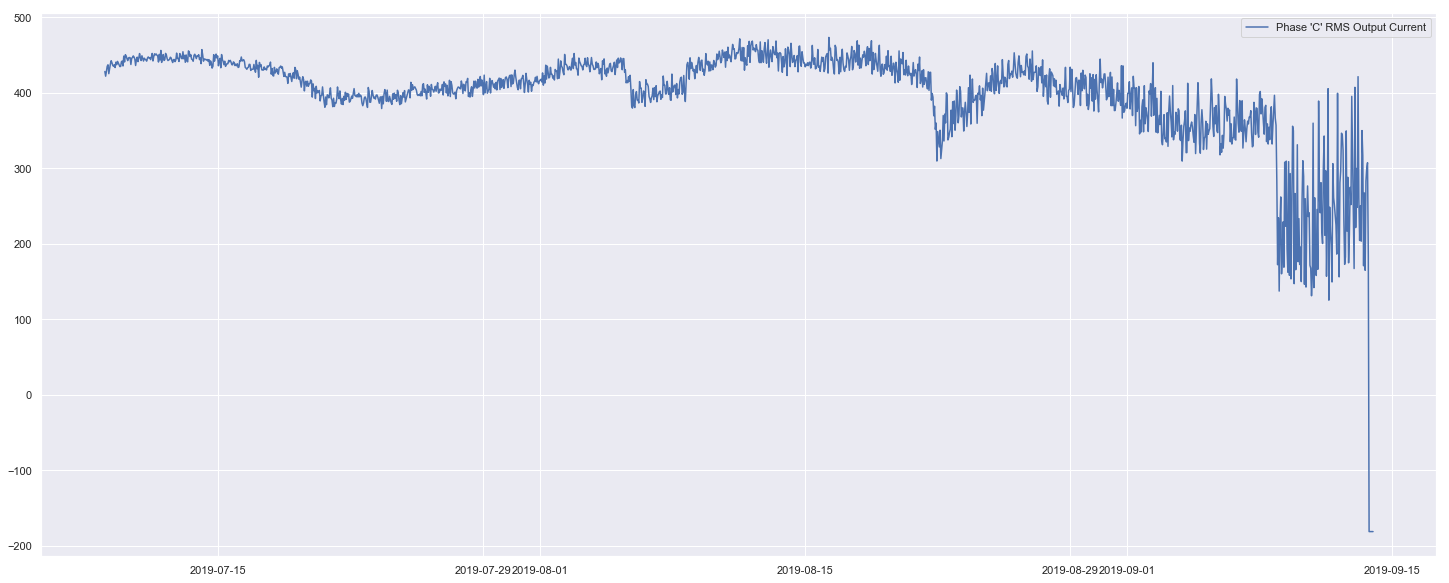

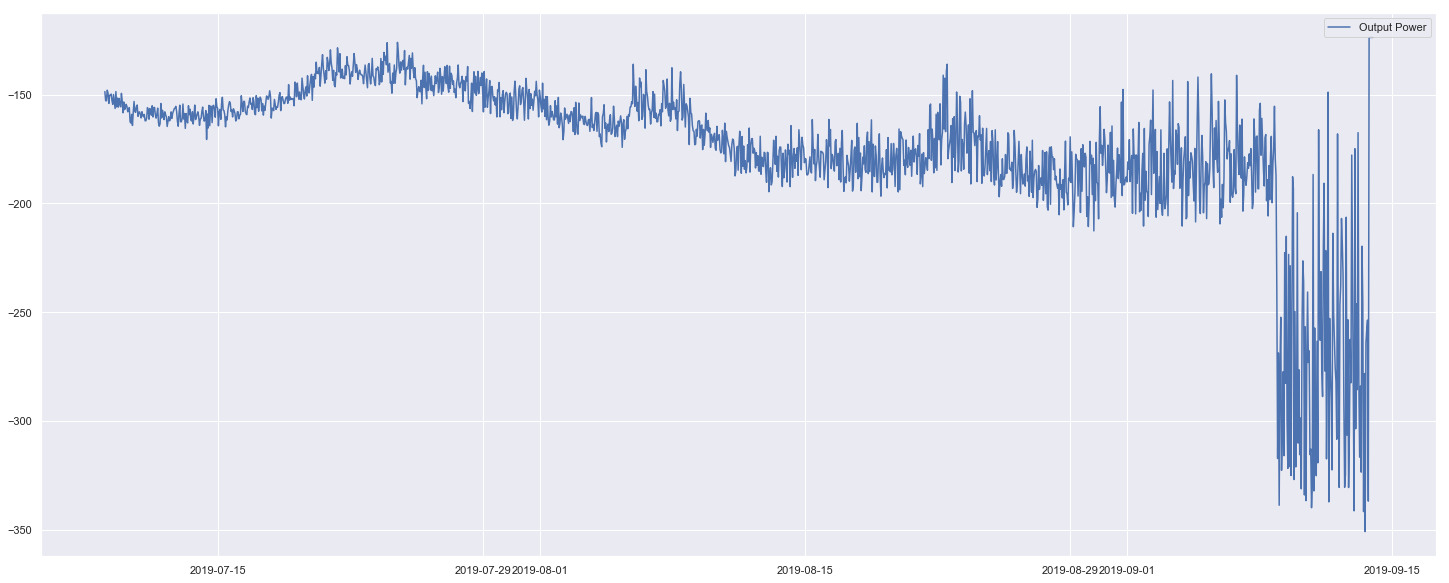

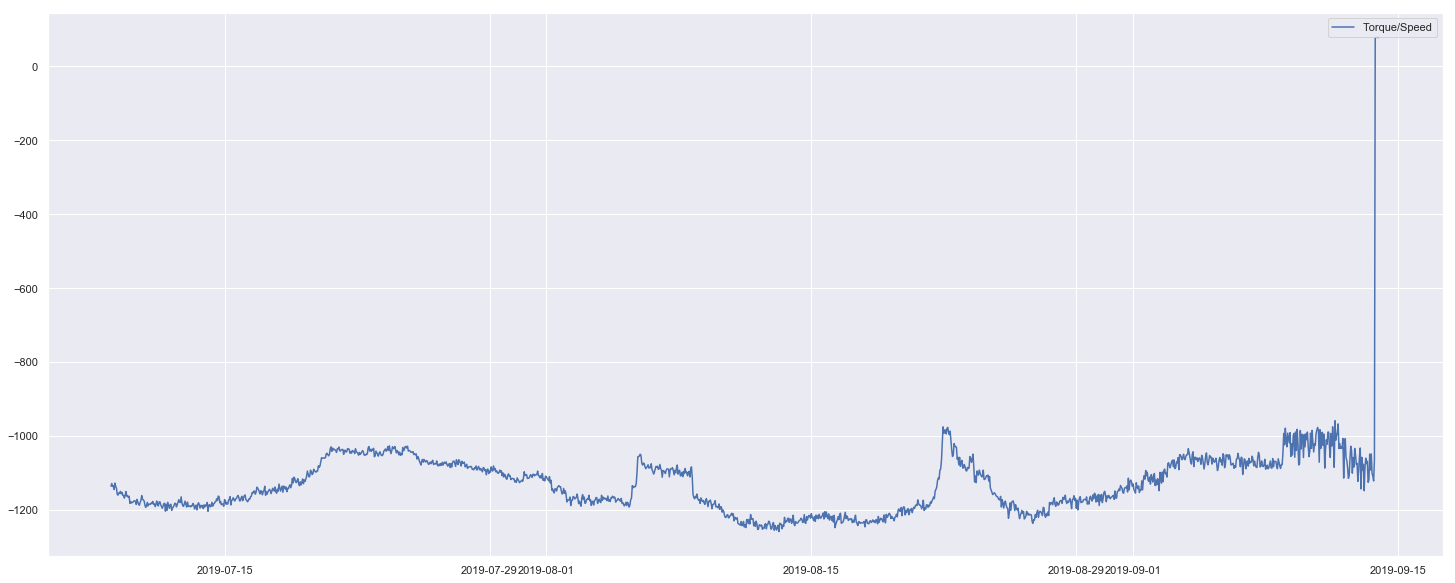

In [57]:
for col in frequency_Df_test.columns:
    plt.figure(figsize=(25,10))
    plt.plot(frequency_Df_test[col])
    plt.legend()
    plt.show()

In [1]:
frequency_Df_test['Motor Speed'].plot(figsize=(20,10))

NameError: name 'frequency_Df_test' is not defined

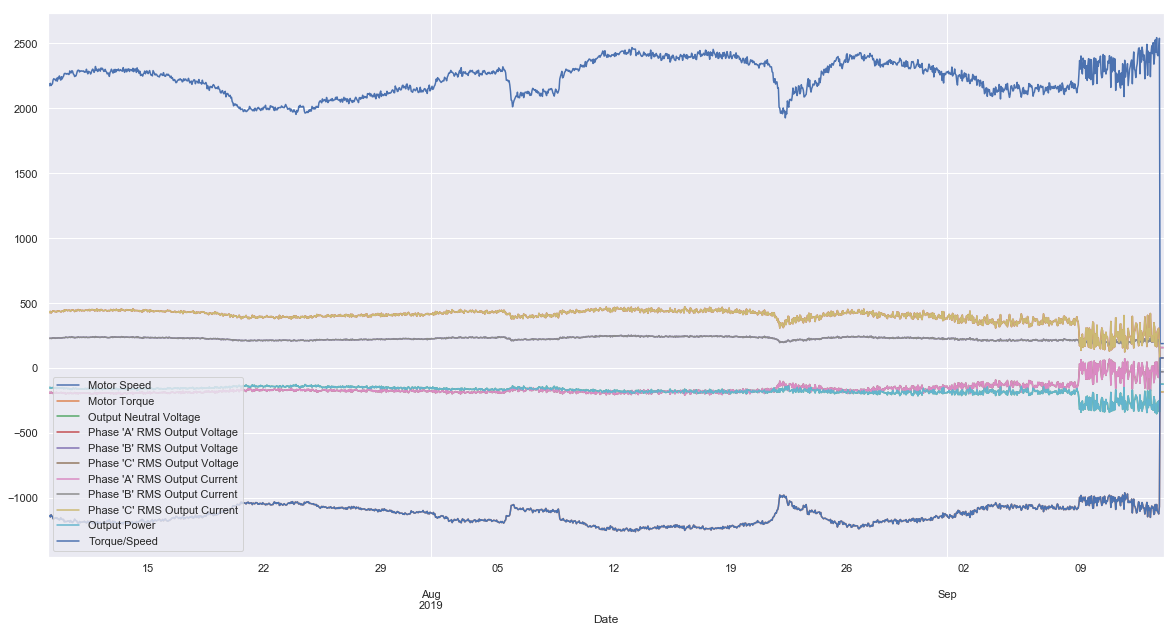

In [97]:
frequency_Df_test.plot(figsize=(20,10))
plt.legend(loc='lower left')
plt.margins(0.05)



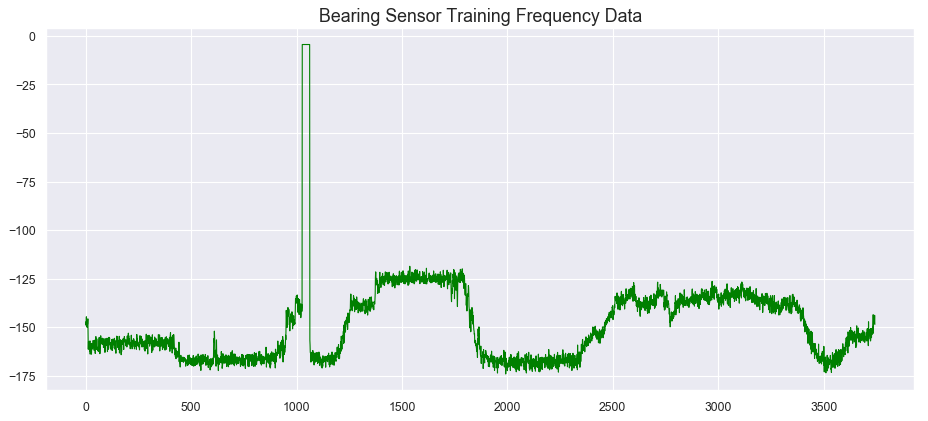

In [50]:
# frequencies of the healthy sensor signal

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
# ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
# ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='NVO', color='green', animated = True, linewidth=1)
# ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
# ax.plot(train_fft[:,4].real, label='Bearing 4', color='black', animated = True, linewidth=1)
# ax.plot(train_fft[:,5].real, label='Bearing 4', color='black', animated = True, linewidth=1)
# ax.plot(train_fft[:,6].real, label='Bearing 4', color='black', animated = True, linewidth=1)
# ax.plot(train_fft[:,7].real, label='Bearing 4', color='black', animated = True, linewidth=1)
# ax.plot(train_fft[:,8].real, label='Bearing 4', color='black', animated = True, linewidth=1)
#ax.plot(train_fft[:,9].real, label='Power', color='black', animated = True, linewidth=1)
# ax.plot(train_fft[:,10].real, label='Bearing 4', color='black', animated = True, linewidth=1)
# plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

In [30]:
# # frequencies of the degrading frequency signal

# fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
# ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
# ax.plot(test_fft[:,1].real, label='Bearing 2', color='red', animated = True, linewidth=1)
# ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
# ax.plot(test_fft[:,3].real, label='Bearing 4', color='orange', animated = True, linewidth=1)
# ax.plot(test_fft[:,4].real, label='Bearing 4', color='yellow', animated = True, linewidth=1)
# ax.plot(test_fft[:,5].real, label='Bearing 4', color='brown', animated = True, linewidth=1)
# ax.plot(test_fft[:,6].real, label='Bearing 4', color='white', animated = True, linewidth=1)
# ax.plot(test_fft[:,7].real, label='Bearing 4', color='purple', animated = True, linewidth=1)
# ax.plot(test_fft[:,8].real, label='Bearing 4', color='violet', animated = True, linewidth=1)
# ax.plot(test_fft[:,9].real, label='Bearing 4', color='pink', animated = True, linewidth=1)
# ax.plot(test_fft[:,10].real, label='Bearing 4', color='black', animated = True, linewidth=1)
# plt.legend(loc='lower left')
# ax.set_title('VFD Test Frequency Data', fontsize=16)
# plt.show()

In [62]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [63]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (3744, 1, 11)
Test data shape: (1609, 1, 11)


In [64]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='elu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='elu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='elu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='elu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [65]:


# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 11)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             1792      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 11)             187       
Total para

In [73]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.1).history

Train on 3369 samples, validate on 375 samples
Epoch 1/100
3369/3369 [==============================] - 3s 778us/step - loss: 0.0154 - val_loss: 0.0238
Epoch 2/100
3369/3369 [==============================] - 3s 863us/step - loss: 0.0153 - val_loss: 0.0248
Epoch 3/100
3369/3369 [==============================] - 2s 718us/step - loss: 0.0152 - val_loss: 0.0236
Epoch 4/100
3369/3369 [==============================] - 3s 758us/step - loss: 0.0154 - val_loss: 0.0240
Epoch 5/100
3369/3369 [==============================] - 3s 816us/step - loss: 0.0153 - val_loss: 0.0239
Epoch 6/100
3369/3369 [==============================] - 3s 767us/step - loss: 0.0152 - val_loss: 0.0236
Epoch 7/100
3369/3369 [==============================] - 3s 764us/step - loss: 0.0152 - val_loss: 0.0238
Epoch 8/100
3369/3369 [==============================] - 3s 813us/step - loss: 0.0151 - val_loss: 0.0244
Epoch 9/100
3369/3369 [==============================] - 3s 766us/step - loss: 0.0150 - val_loss: 0.0232
Epoch 10

Epoch 78/100
3369/3369 [==============================] - 3s 825us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 79/100
3369/3369 [==============================] - 3s 834us/step - loss: 0.0045 - val_loss: 0.0051
Epoch 80/100
3369/3369 [==============================] - 3s 829us/step - loss: 0.0045 - val_loss: 0.0055
Epoch 81/100
3369/3369 [==============================] - 3s 887us/step - loss: 0.0046 - val_loss: 0.0050
Epoch 82/100
3369/3369 [==============================] - 3s 817us/step - loss: 0.0045 - val_loss: 0.0056
Epoch 83/100
3369/3369 [==============================] - 3s 979us/step - loss: 0.0044 - val_loss: 0.0052
Epoch 84/100
3369/3369 [==============================] - 5s 1ms/step - loss: 0.0044 - val_loss: 0.0056
Epoch 85/100
3369/3369 [==============================] - 3s 824us/step - loss: 0.0044 - val_loss: 0.0051
Epoch 86/100
3369/3369 [==============================] - 3s 828us/step - loss: 0.0045 - val_loss: 0.0052
Epoch 87/100
3369/3369 [========================

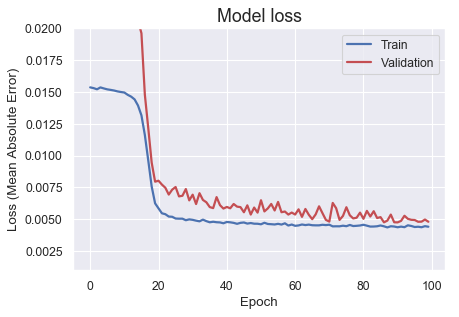

In [92]:
fig, ax = plt.subplots( dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (Mean Absolute Error)')
ax.set_xlabel('Epoch')
plt.ylim([0.001,.02])
ax.legend(loc='upper right')
plt.show()

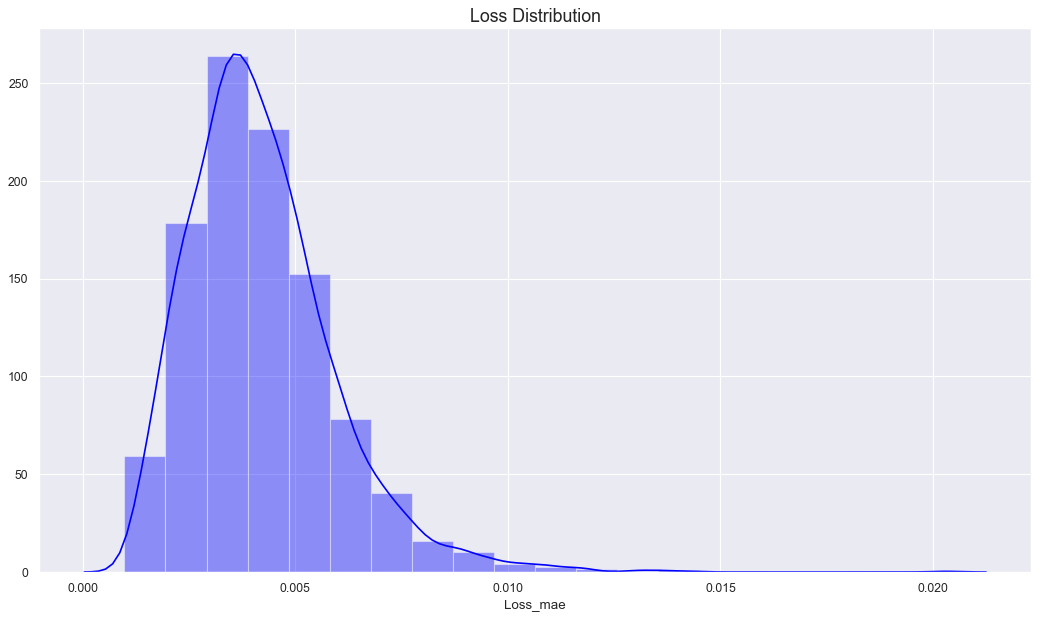

In [75]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


In [93]:


# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.025
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()



,Loss_mae,Threshold,Anomaly
Date,,,
2019-07-09 00:00:00,0.004198,0.025,False
2019-07-09 01:00:00,0.020386,0.025,False
2019-07-09 02:00:00,0.008503,0.025,False
2019-07-09 03:00:00,0.003568,0.025,False
2019-07-09 04:00:00,0.003439,0.025,False


In [94]:
scored[(scored['Anomaly'] == True)& (scored['Loss_mae'] > 0.025)]

,Loss_mae,Threshold,Anomaly
Date,,,
2019-07-13 06:00:00,0.063987,0.025,True
2019-07-13 09:00:00,0.037006,0.025,True
2019-07-13 16:00:00,0.031444,0.025,True
2019-07-14 09:00:00,0.052968,0.025,True
2019-07-14 11:00:00,0.029359,0.025,True
...,...,...,...
2019-09-13 20:00:00,1.775916,0.025,True
2019-09-13 21:00:00,1.775916,0.025,True
2019-09-13 22:00:00,1.775916,0.025,True


In [95]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.03
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

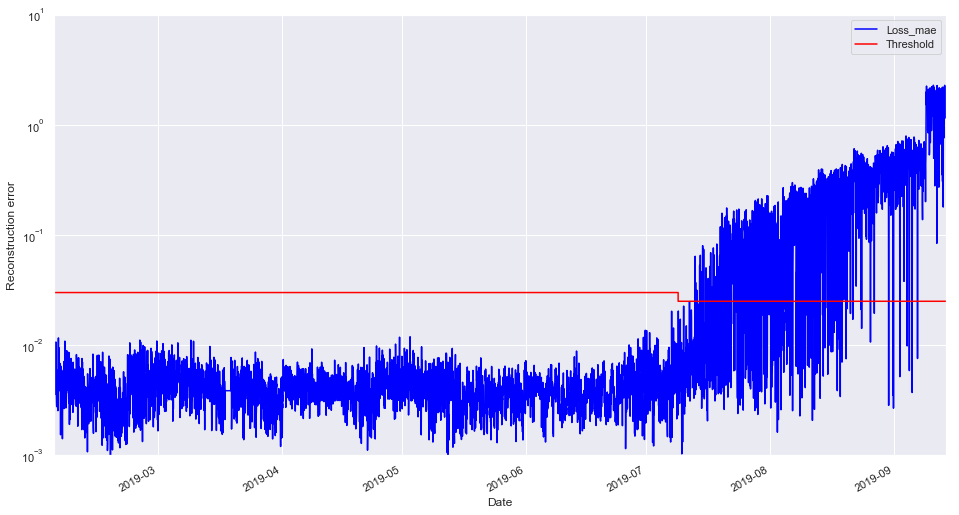

In [101]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-3,1e1], color=['blue','red'])
plt.ylabel("Reconstruction error")
plt.show()

In [37]:
X_train.shape

(3744, 1, 11)

In [38]:
# imp = preprocessing.Imputer(strategy="mean", axis=0)

In [39]:
# scaler = preprocessing.MinMaxScaler()
# X_train = pd.DataFrame(scaler.fit_transform(imp.fit_transform(train)),
#                           columns = train.columns,
#                           index=train.index)

In [40]:
# X_test = pd.DataFrame(scaler.transform(imp.transform(train)),
#                          columns = train.columns,
#                          index = train.index)

In [41]:
# seed(10)

# activation_function = 